# Monyhub Data Science exercise

## Overview
In the Data Scientist job description, one of the areas you'll be working in is as follows:

_"The development of targeted nudges based on current and historical data to ensure financial wellness.  As an example, a well known principle is that users should spend 50% of their net income on essential expenses, 30% on wants and 20% on savings & investments; you could be developing techniques to measure how well someone aligns with this viewpoint and helping the user achieve a state of financial zen."_

The task is to use the provided data to show some interesting insight that relates to the above. 

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set seaborn style 
sns.set(style="darkgrid")
sns.set(font_scale=1.5)

# Other
import missingno as msno

## Read Data and raw exploration


In [2]:
# Read data
raw_amounts = pd.read_csv('../data/user_category_amount.csv')
raw_amounts.info()
raw_amounts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2871 entries, 0 to 2870
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   2871 non-null   object 
 1   category  2871 non-null   object 
 2   total     2871 non-null   float64
 3   month     2871 non-null   object 
dtypes: float64(1), object(3)
memory usage: 89.8+ KB


user_id    category  total    month
0  0354794f53a874c16eef7a10a67f8b96e47ec454  automotive -13.12  2021-03
1  0354794f53a874c16eef7a10a67f8b96e47ec454  automotive -13.12  2021-04
2  0354794f53a874c16eef7a10a67f8b96e47ec454  automotive -13.12  2021-05
3  0354794f53a874c16eef7a10a67f8b96e47ec454       cable -36.53  2021-03
4  0354794f53a874c16eef7a10a67f8b96e47ec454       cable -36.53  2021-04

In [3]:
# Raw exploration
# user_id
print('There are',len(raw_amounts['user_id'].unique()),'unique users in our dataset \n')

# month
print('Date range on dataset: (',min(pd.to_datetime(raw_amounts['month'])),'-',max(pd.to_datetime(raw_amounts['month'])),')\n')

# category
print('There are',len(raw_amounts['category'].unique()),'unique categories covered, including:')
print(raw_amounts['category'].unique())

There are 100 unique users in our dataset 

Date range on dataset: ( 2021-03-01 00:00:00 - 2021-05-01 00:00:00 )

There are 19 unique categories covered, including:
['automotive' 'cable' 'groceries' 'insurance' 'loans' 'mortgages'
 'paychecks' 'restaurants' 'service' 'taxes' 'telephone' 'utilities'
 'healthcare' 'other-income' 'rent' 'child' 'retirement' 'investment'
 'education']


# Cleaning and Pre-processing

The dataset suffers from a number of problems:

- It is incomplete, part of the task is determining what you can show reliably.
- No transaction categorisation engine is perfect, some of the calculated category spends may be incorrect. You may want to use a strategy, ideally a simple one, that minimises this issue and explain how what you've done mitigates it.
- This is a small sample of users, how valid are any conclusions for the population at large?

## Transform data

- We can pivot data so we can have it in tabular format (i.e. income/expenses categories for every user and month)


## Clean data

- As we have 3 months worth of data for each user - we could aggregate data at user level using the median values (within 3 month period) to better estimate spendings on every category for each individual user. This could help us discard outliers or erroneos values at the user level. However, this would reduce data instances by a factor of 3. I avoid using the mean because it suffers more the presence of outliers.

- Additionally, we could instead analyze values at category level (i.e across columns of pivoted DataFrame). For example, by analyzing the distribution of each category using histograms/boxplots we could identify outliers and discard them using different criteria. For instance:
    - Discard negative incomes (unless they seem logical i.e. investments that went wrong)
    - Discard positive expenses (unless they seem logical i.e. tax refund)
    - Discard values that are too extreme for the usual observation. I.e. discard values outside 1.5 times interquantile range - 1.5 (Q3 - Q1) ~ 99% included 
    
- Keep in mind, that the second approach would be most suitable for categories that have plenty of readings (i.e. low number of missing values) and under the assumption that the consumers represented have somewhat similar spending patterns. As this might not be the case, my initial analysis will consider all available data, aggregated at user level except cases were spending values seem ilogical. For similar reasons, I will not be imputting missing values.

    





In [4]:
def index_and_pivot(df, index_cols = ['user_id','month'], feature_cols= 'category', value_cols= 'total', agg=False):

    """
    This function takes a raw DataFrame, builds an index with specified columns and pivots data into a tabular
    format for easier interpretation and exploration. It also provides option to aggregate data at user level.
    
    Args:
        df: pandas DataFrame
        index_cols: list of columns to build index from
        feature_cols: string of column containing name of features (amounts) of interest
        value_cols: string of colum containing values for each feature (amount) of interest
        agg: boolean. If True, aggregate data at `user_id` level using `median`
        

    Returns:
        pivot_df: pivoted pandas DataFrame
        
    """
    
    # Cast date into right format
    if 'month' in index_cols:
        df['month'] =  pd.to_datetime(df['month'])
    
    # Pivot data
    pivoted_df = df.pivot(index=index_cols, columns=feature_cols, values=value_cols)
    
    # Aggregate data if required
    if agg:
        pivoted_df =  pivoted_df.groupby(level='user_id').median()
    
    return pivoted_df

In [5]:
def augment_dataset(df, income_cols, needs_cols, wants_cols, clean=False):
    
    """
    This function takes a pivoted DataFrame and append columns describing: 
    - total_income: sum of income sources
    - total_expends: sum of expenditures
    - pctg_expends: percentage of expends w.r.t. total income
    
    Args:
        df: pandas DataFrame
        income_cols: list of columns representing income sources
        expends_cols: list of columns representing expenditures

    Returns:
        df: DataFrame with additional columns including 
        
    """
    
    # total expends
    expends_cols = needs_cols + wants_cols
    
    if clean:
        # Drop negative incomes
        for col in income_cols:
            df = df.drop(df[df[col] < 0].index)
        # Drop positive expendings
        for col in expends_cols:
            df = df.drop(df[df[col] > 0].index)
    
    # add pctg_expends column
    augmented_df = df.copy()
    augmented_df['total_income'] = df[income_cols].sum(axis = 1)
    augmented_df['total_expends'] = abs(df[expends_cols].sum(axis = 1))
    augmented_df['pctg_expends'] = augmented_df['total_expends']/augmented_df['total_income'] * 100.0
    
    return augmented_df

In [6]:
# Pivoted data
# pivoted_df = index_and_pivot(raw_amounts, agg = False)
pivoted_df = index_and_pivot(raw_amounts, agg = True)
pivoted_df

category                                  automotive  cable  child  education  \
user_id                                                                         
0354794f53a874c16eef7a10a67f8b96e47ec454      -13.12 -36.53    NaN        NaN   
051b40d545a7e3ff3133892e46821d73ce5a677b         NaN    NaN    NaN        NaN   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8         NaN    NaN    NaN        NaN   
069a2b627835fe2093080c9af2b7247105850c45         NaN -14.31    NaN        NaN   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd      -35.60 -81.50    NaN        NaN   
...                                              ...    ...    ...        ...   
f6f89ce731e149d025334318a4e61f248ffd1d38      -35.91 -39.99    NaN        NaN   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a         NaN -74.42    NaN        NaN   
f8032ac437a8b748b8bcad2b2e8afadc884ca568         NaN -45.11    NaN     -100.0   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b         NaN -19.99    NaN        NaN   
f931d574523248dfcff32e04e560f943783bc072         NaN -85.19    NaN        NaN   

category                                  groceries  healthcare  insurance  \
user_id                                                                      
0354794f53a874c16eef7a10a67f8b96e47ec454    -457.03         NaN     -36.03   
051b40d545a7e3ff3133892e46821d73ce5a677b    -521.97         NaN     -19.27   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8    -271.51         NaN     -16.02   
069a2b627835fe2093080c9af2b7247105850c45    -256.01      -10.59     -38.97   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd    -210.95         NaN        NaN   
...                                             ...         ...        ...   
f6f89ce731e149d025334318a4e61f248ffd1d38    -928.05         NaN     -84.00   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a    -201.66         NaN     -16.76   
f8032ac437a8b748b8bcad2b2e8afadc884ca568    -818.22         NaN     -18.69   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b    -343.59         NaN        NaN   
f931d574523248dfcff32e04e560f943783bc072    -583.61         NaN        NaN   

category                                  investment   loans  mortgages  \
user_id                                                                   
0354794f53a874c16eef7a10a67f8b96e47ec454         NaN -145.41    -460.02   
051b40d545a7e3ff3133892e46821d73ce5a677b         NaN     NaN   -1128.53   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8         NaN     NaN    -348.43   
069a2b627835fe2093080c9af2b7247105850c45         NaN     NaN        NaN   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd         NaN -154.92        NaN   
...                                              ...     ...        ...   
f6f89ce731e149d025334318a4e61f248ffd1d38         NaN     NaN        NaN   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a         NaN     NaN        NaN   
f8032ac437a8b748b8bcad2b2e8afadc884ca568         NaN     NaN        NaN   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b         NaN     NaN    -778.69   
f931d574523248dfcff32e04e560f943783bc072         NaN     NaN   -1038.66   

category                                  other-income  paychecks   rent  \
user_id                                                                    
0354794f53a874c16eef7a10a67f8b96e47ec454           NaN   2553.000    NaN   
051b40d545a7e3ff3133892e46821d73ce5a677b           NaN   5537.305    NaN   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8           NaN   2044.090    NaN   
069a2b627835fe2093080c9af2b7247105850c45          3.49   1282.480    NaN   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd        100.00   1493.110 -390.0   
...                                                ...        ...    ...   
f6f89ce731e149d025334318a4e61f248ffd1d38           NaN   5482.440    NaN   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a           NaN        NaN    NaN   
f8032ac437a8b748b8bcad2b2e8afadc884ca568          5.53   2675.950    NaN   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b           NaN   3327.990    NaN   
f931d574523248dfcff32e04e560f943783bc072   

## Exploratory Data Analysis (EDA)

### Analyze missing values

In terms of income:
- We observe high sparcity on `investment` and `retirement` columns. Majority of income source in our dataset comes from `paychecks` which in some cases is complemented with `other-income` source

In terms of expenses:
- We can observe relatively high sparsity on `rent` but many of those users pay a `mortgage`. However, 27 users don't pay either.
- Other highly sparse variables include `automotive`, `healthcare`, `child` and`education`


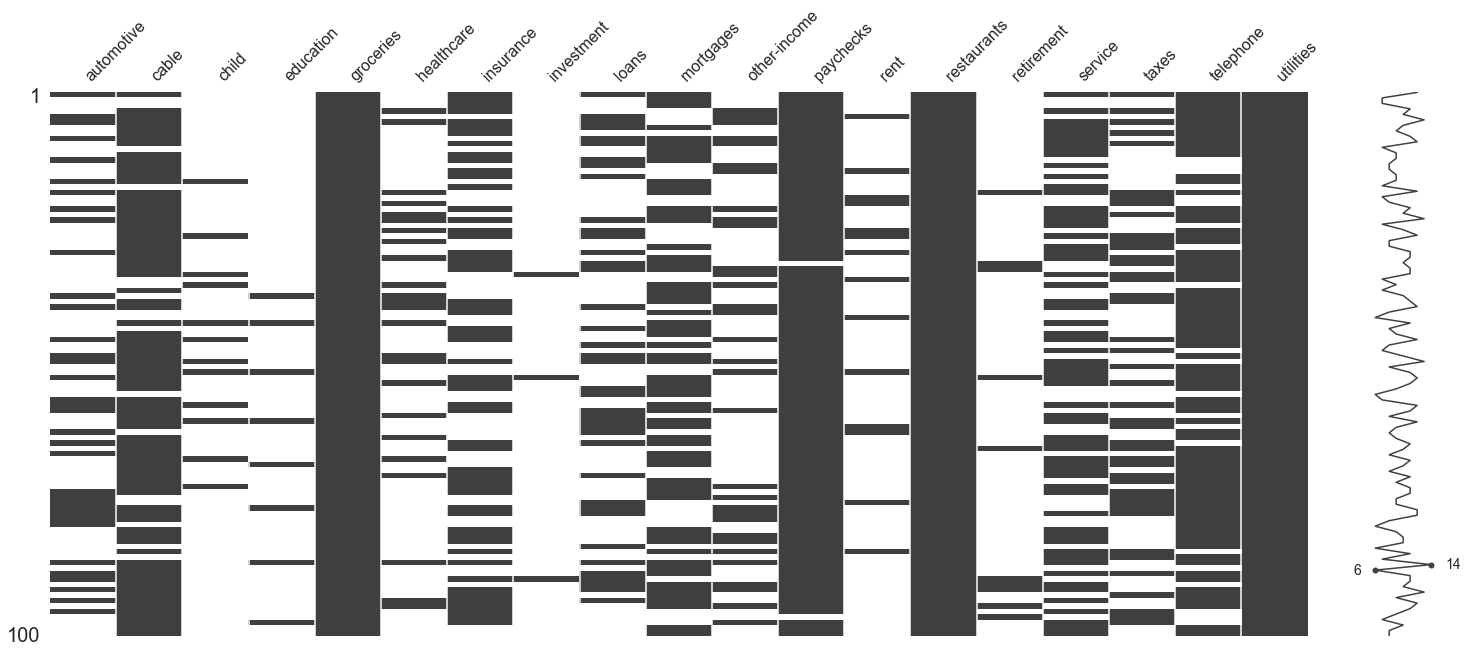

In [7]:
# Visualize distribution of missing values accross columns. Missing in white
msno.matrix(pivoted_df)
plt.show()

In [8]:
# Users without rent or mortgage
print("Users not paying rent or morgage:",
      len(pivoted_df[pivoted_df['rent'].isnull() & pivoted_df['mortgages'].isnull()].groupby(level='user_id')))

# Expenses with high sparcity
print('Ids without automotive expenses:',len(pivoted_df[pivoted_df['automotive'].isnull()].groupby(level='user_id').median()))
print('Ids without healthcare expenses:',len(pivoted_df[pivoted_df['healthcare'].isnull()].groupby(level='user_id').median()))
print('Ids without child expenses:',len(pivoted_df[pivoted_df['child'].isnull()].groupby(level='user_id').median()))
print('Ids without education expenses:',len(pivoted_df[pivoted_df['education'].isnull()].groupby(level='user_id').median()))

Users not paying rent or morgage: 27
Ids without automotive expenses: 65
Ids without healthcare expenses: 76
Ids without child expenses: 88
Ids without education expenses: 92


### Define income/expenditures

Determining **NEEDS**: these are expenditures that are **essential** for us to be able to live and work. They’re the recurring expenses that are likely to eat up a large chunk of our paycheck. 

**Note: common utilities include water, sewer, electric, gas, trash, and recycling. Technology subscriptions like cable, telephone, etc can also be considered utilities.**

Determining **WANTS**: these are expenses that help us live more comfortably. They’re the things we buy for fun or leisure. We could live without them, but we enjoy our lives more when we have them. For instance, food is a need, but daily lunches out are likely more of a want. Wants typically include things such as:
- Restaurants/Especialty coffee
- Travel
- Entertainment
- Designer clothing
- Gym memberships


**Note: I will assume that most of the fields on our dataset are essential except for `restaurants`. One could argue `automotive` is not essential but many people will rely on cars for working. Additionally, not everyone will have expends on a `child` but when they do, expenditures on `education` , `child` and `loans` (i.e. for paying education or cars may become essential)**

In [9]:
income_cols = ['paychecks','investment','retirement','other-income']
needs_cols = ['automotive', 'child', 
              'education', 'loans', 
              'mortgages', 'rent', 'insurance', 'taxes', 'service', 
              'cable',  'telephone', 'utilities', 'groceries', 'healthcare']
wants_cols = ['restaurants']

### Describe variables

- Negative values in `investment` could be due to error or that specific investment going wrong for the user
- Positive values observed in `rent` could be either errors or a source of income for that specific user
- Positive values for `taxes` could be either errors or source of income for the user getting tax refund



In [10]:
def summary_stats(df, col, verbose = False):
    
    """
    This function takes a DataFrame and a inspects one column returning several summary statistics
    
    Args:
        df: pd.DataFrame
        column: variable to check

    Returns:
        median, mean , std, mini, maxi: floats
    """
    
    # Find statistics
    median = df[col].median()
    mean = df[col].mean()
    std = df[col].std()
    mini = df[col].min()
    maxi = df[col].max()
    
    if verbose:
        print("Median:", round(median,3))
        print("Mean:", round(mean,3) )
        print("Standard deviation:", round(std,3) )
        print("Minimun number:", mini)
        print("Maximun number:", maxi)

    return median, mean, std, mini, maxi

In [11]:
# Check income/expenditures statistics
pivoted_df.describe().transpose()

count         mean          std      min        25%       50%  \
category                                                                      
automotive     35.0  -164.820571   201.989300  -603.84  -222.6450   -46.730   
cable          83.0   -53.540555    39.261523  -174.52   -80.1700   -43.120   
child          12.0  -292.690000   243.383825  -740.00  -480.2500  -170.000   
education       8.0  -155.748750   196.962412  -588.56  -214.3975   -68.425   
groceries     100.0  -441.762000   259.316592 -1159.22  -588.7600  -367.300   
healthcare     24.0   -31.682083    34.016843  -140.00   -39.0300   -19.900   
insurance      55.0   -53.894545    47.355287  -206.35   -73.6100   -38.970   
investment      3.0   566.666667  1573.478101 -1250.00   100.0000  1450.000   
loans          39.0  -274.940513   218.991928 -1113.15  -340.2500  -265.400   
mortgages      61.0  -947.491370   652.428753 -3444.53 -1172.2300  -824.300   
other-income   32.0   393.016390   668.889650     1.55     5.2475    90.650   
paychecks      98.0  3572.467846  1709.498770   656.40  2236.2700  3413.995   
rent           14.0  -673.515714   864.603032 -2125.00 -1208.8900  -505.000   
restaurants   100.0  -201.699600   155.269399  -723.47  -266.9550  -157.915   
retirement     10.0  1474.685000  1310.610537   281.42   668.8500   887.455   
service        61.0   -14.042623    20.356799  -146.03   -17.0000    -8.000   
taxes          43.0  -175.871860    94.677109  -342.00  -228.2650  -174.000   
telephone      79.0   -40.026203    37.674143  -207.51   -53.9950   -30.000   
utilities     100.0  -137.824600    95.344590  -483.00  -192.5000  -107.580   

                    75%      max  
category                          
automotive     -24.6900    -0.87  
cable          -19.6750    -3.00  
child         -128.1175   -26.43  
education      -27.1425   -10.00  
groceries     -242.0775   -22.20  
healthcare     -10.5900    -7.94  
insurance      -18.3400    -4.37  
investment    1475.0000  1500.00  
loans         -137.2700    -9.75  
mortgages     -530.1500   -23.56  
other-income   513.8425  3084.94  
paychecks     4626.5525  9534.89  
rent          -157.0750   825.00  
restaurants    -91.9100   -15.52  
retirement    1583.4750  4280.72  
service         -4.0000    -0.23  
taxes         -131.2200   233.93  
telephone      -14.2500    -4.74  
utilities      -70.4000    -3.50

### Visualize Distributions

In [12]:
def plot_distribution(df, col, title = '', bins = 30, quantile = '', alpha=None, annotation=None):
    
    """
    This function takes a DataFrame and a inspects one column returning both a histogram and a corresponding boxplot
    Allows to pick number of bins and control x-axis limit with quantile parameter
    
    Args:
        df: pd.DataFrame
        column: variable to check

    Returns:
        None
    """
    
    
    # Extract data
    series = df[col]
    # Create a figure for 2 subplots
    fig, ax = plt.subplots(2,1,figsize = (10,10))
    # Plot histogram
    ax[0].hist(series, bins = bins)
    ax[0].axvline(series.mean(), color = 'magenta', linestyle = 'dashed', linewidth = 2)
    ax[0].axvline(series.median(), color = 'cyan', linestyle = 'dashed', linewidth = 2)
    ax[0].set_xlabel(title, fontsize = 16)
    ax[0].set_ylabel('counts', fontsize = 16)
    if quantile != '':
        ax[0].set_xlim(0,df[col].quantile(q=quantile))
    

    # Plot boxplot
    ax[1].boxplot(series, vert = False)
    ax[1].set_xlabel(title, fontsize = 16)
    ax[1].set_ylabel('', fontsize = 16)
    if quantile != '':
        ax[1].set_xlim(0,df[col].quantile(q=quantile))

    if alpha:
        ax[1].axvspan(0,50, color ='g', alpha = alpha)    
        ax[1].axvspan(50,80, color ='orange', alpha = alpha)   
        ax[1].axvspan(80,100, color ='red', alpha = alpha)   
        ax[1].axvspan(100,125, color ='magenta', alpha = alpha)
        
        
    if annotation:
        fs = 12
        ax[1].annotate('Needs', (25, 1.3), fontsize = fs, weight = 'bold' )
        ax[1].annotate('Wants', (60, 1.3), fontsize = fs, weight = 'bold')
        ax[1].annotate('Savings', (85, 1.3), fontsize = fs, weight = 'bold' )
        ax[1].annotate('Overspending',(101, 1.3), fontsize = fs, weight = 'bold' )
    
    # Add title
    fig.suptitle(f'Distribution of {title}')

    # Show figure
    plt.show()
    
    return None

In [13]:
# Map variables into dictionary
columns_dict = {i:j for i,j in enumerate(pivoted_df.columns)}
print(columns_dict)

{0: 'automotive', 1: 'cable', 2: 'child', 3: 'education', 4: 'groceries', 5: 'healthcare', 6: 'insurance', 7: 'investment', 8: 'loans', 9: 'mortgages', 10: 'other-income', 11: 'paychecks', 12: 'rent', 13: 'restaurants', 14: 'retirement', 15: 'service', 16: 'taxes', 17: 'telephone', 18: 'utilities'}


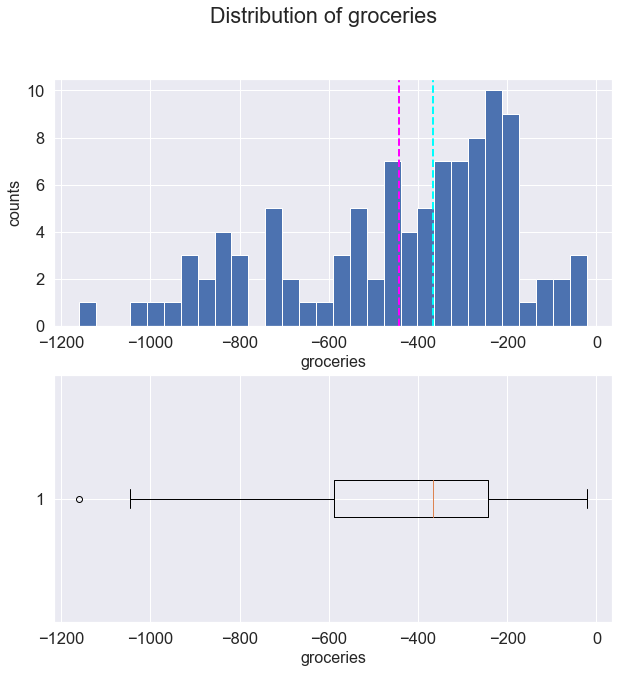

In [14]:
# Plot column distribution
column = columns_dict[4]
plot_distribution(pivoted_df, column, str(column))

### Outliers

In [15]:
def plot_boxplots(df, title='', size = (10,10)):

    # Plot defining figure and axis
    fig = plt.figure(figsize=size)
    ax = fig.gca()
    
    # Setting axes labels
    ax.set_xlabel(title, fontsize = 16)
    ax.set_ylabel('Urea Price', fontsize = 16)
    # Title
    ax.set_title(title, fontsize = 16)
    
    # Define feature to plot
    data = df
    
    # Boxplots
    sns.boxplot(data=data, orient='h' , ax=ax)  
    plt.show()

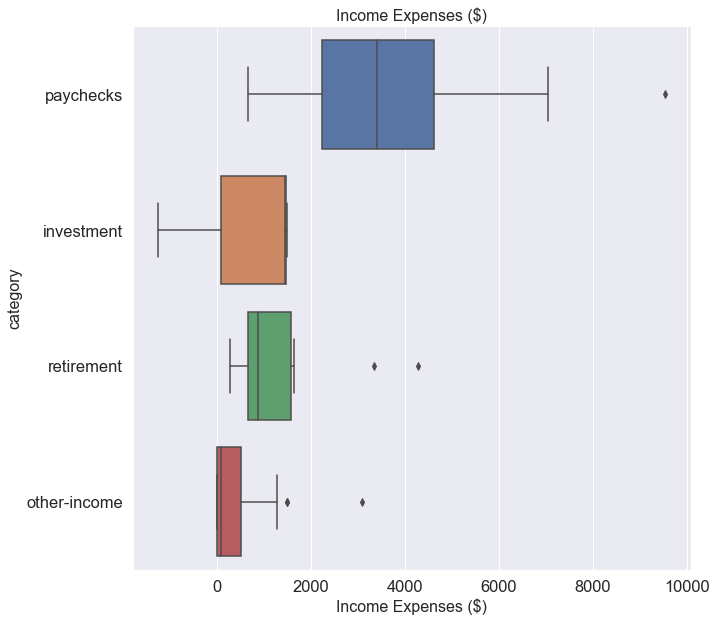

In [16]:
# Income boxplots
plot_boxplots(pivoted_df[income_cols], 'Income Expenses ($)')

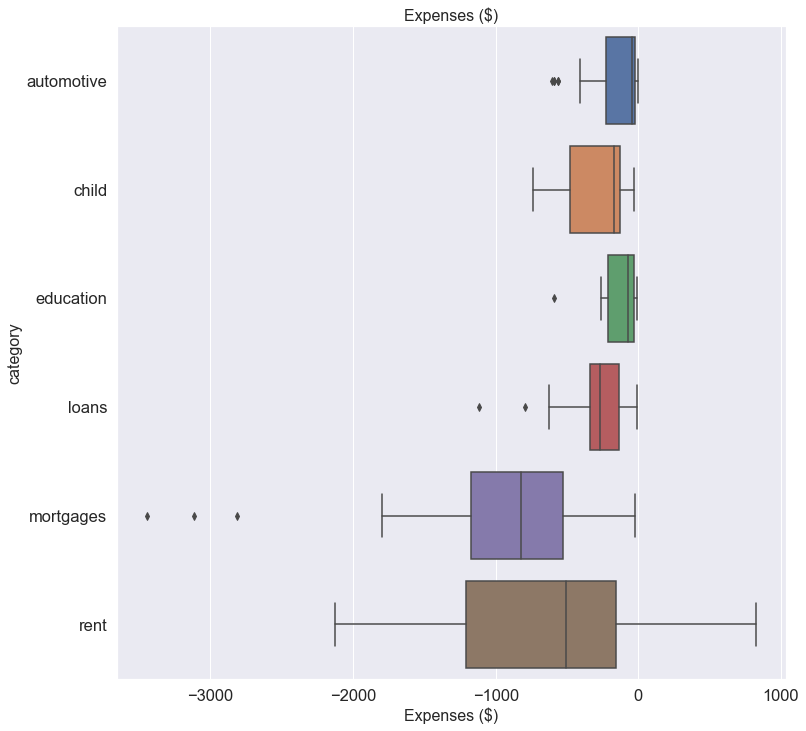

In [17]:
# Essential expenses 1
plot_boxplots(pivoted_df[needs_cols[0:6]], 'Expenses ($)', (12,12))

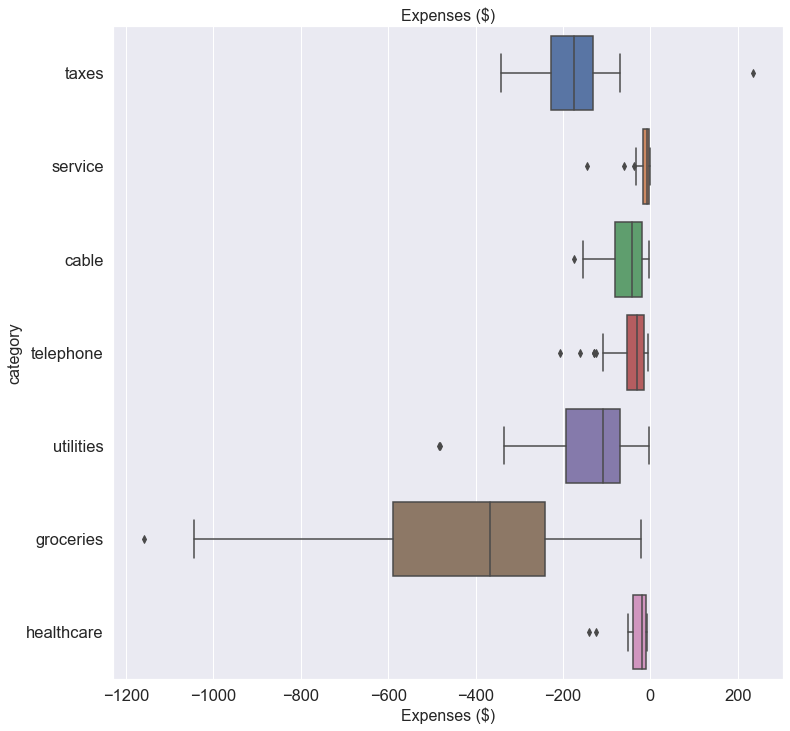

In [18]:
# Essential expenses 2
plot_boxplots(pivoted_df[needs_cols[7:14]], 'Expenses ($)', (12,12))

In [19]:
# Obtain augmented dataframe
results_df = augment_dataset(pivoted_df,income_cols,needs_cols, wants_cols, clean = False)
results_df

category                                  automotive  cable  child  education  \
user_id                                                                         
0354794f53a874c16eef7a10a67f8b96e47ec454      -13.12 -36.53    NaN        NaN   
051b40d545a7e3ff3133892e46821d73ce5a677b         NaN    NaN    NaN        NaN   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8         NaN    NaN    NaN        NaN   
069a2b627835fe2093080c9af2b7247105850c45         NaN -14.31    NaN        NaN   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd      -35.60 -81.50    NaN        NaN   
...                                              ...    ...    ...        ...   
f6f89ce731e149d025334318a4e61f248ffd1d38      -35.91 -39.99    NaN        NaN   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a         NaN -74.42    NaN        NaN   
f8032ac437a8b748b8bcad2b2e8afadc884ca568         NaN -45.11    NaN     -100.0   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b         NaN -19.99    NaN        NaN   
f931d574523248dfcff32e04e560f943783bc072         NaN -85.19    NaN        NaN   

category                                  groceries  healthcare  insurance  \
user_id                                                                      
0354794f53a874c16eef7a10a67f8b96e47ec454    -457.03         NaN     -36.03   
051b40d545a7e3ff3133892e46821d73ce5a677b    -521.97         NaN     -19.27   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8    -271.51         NaN     -16.02   
069a2b627835fe2093080c9af2b7247105850c45    -256.01      -10.59     -38.97   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd    -210.95         NaN        NaN   
...                                             ...         ...        ...   
f6f89ce731e149d025334318a4e61f248ffd1d38    -928.05         NaN     -84.00   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a    -201.66         NaN     -16.76   
f8032ac437a8b748b8bcad2b2e8afadc884ca568    -818.22         NaN     -18.69   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b    -343.59         NaN        NaN   
f931d574523248dfcff32e04e560f943783bc072    -583.61         NaN        NaN   

category                                  investment   loans  mortgages  ...  \
user_id                                                                  ...   
0354794f53a874c16eef7a10a67f8b96e47ec454         NaN -145.41    -460.02  ...   
051b40d545a7e3ff3133892e46821d73ce5a677b         NaN     NaN   -1128.53  ...   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8         NaN     NaN    -348.43  ...   
069a2b627835fe2093080c9af2b7247105850c45         NaN     NaN        NaN  ...   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd         NaN -154.92        NaN  ...   
...                                              ...     ...        ...  ...   
f6f89ce731e149d025334318a4e61f248ffd1d38         NaN     NaN        NaN  ...   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a         NaN     NaN        NaN  ...   
f8032ac437a8b748b8bcad2b2e8afadc884ca568         NaN     NaN        NaN  ...   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b         NaN     NaN    -778.69  ...   
f931d574523248dfcff32e04e560f943783bc072         NaN     NaN   -1038.66  ...   

category                                   rent  restaurants  retirement  \
user_id                                                                    
0354794f53a874c16eef7a10a67f8b96e47ec454    NaN       -58.41         NaN   
051b40d545a7e3ff3133892e46821d73ce5a677b    NaN       -93.18         NaN   
063bb2e5bb8d96e4dbeb499352441a1a4121c0e8    NaN       -91.04         NaN   
069a2b627835fe2093080c9af2b7247105850c45    NaN       -36.60         NaN   
078ec1d2ecd4f5f853dfcf3b69e9dd436a350ccd -390.0      -573.61         NaN   
...                                         ...          ...         ...   
f6f89ce731e149d025334318a4e61f248ffd1d38    NaN      -621.03         NaN   
f746c2ae1e375953c7ecc5f0b5b45ffba3f1df2a    NaN       -38.00     4280.72   
f8032ac437a8b748b8bcad2b2e8afadc884ca568    NaN      -295.37         NaN   
f8a8c1e4ecd3eb773706a9415e832bfc9660446b    NaN      -

## Visualize results and conclusions

To obtain an insight relevant to our rule of thumb I produced a Histogram + Boxplot showing the Percentage of Expends for our data (aggregated at user level). We discussed above that our data includes mainly ESSENTIAL expendings + some data that could be considered as WANTS (i.e. restaurants as an optional expending). 

- For users showing healthy expending patterns, we would like to see their PERCENTAGE_EXPENDINGS w.r.t. to their TOTAL_INCOME to sit somewhere between 50-60%. Ideally, leaning towards 50% as we do not have complete data on their NON_ESSENTIAL expenses.
- From the resulting distribution we see that the medidan and mean PERCENTAGE_EXPENDINGS sit around 51.1% and 53.1% respectively
- We also see that only around 62% of people expend less than 60% of their income in ESSENTIAL + RESTAURANT expenses
- Around 16% of users expend 80% or more of their total income.
- Lastly, there is 2% of people expending more than 100% of their total income

In [20]:
# Obtain summary statistics
stats = summary_stats(results_df, 'pctg_expends', True)

def inverse_percentile(arr, num):
    """
    This function takes an array and a certain percentage of expendings and 
    returns the corresponding percentile of that number
    
    Args:
    arr: pandas Series
    num: float (percentage of expending w.r.t. income)
    
    Returns:
    percentile: float in rangee [0,1]
    
    """
    
    arr = sorted(arr)
    i_arr = [i for i, x in enumerate(arr) if x > num]
    percentile = i_arr[0] / len(arr) if len(i_arr) > 0 else 1
    return round(percentile,2)

# Quantiles
# print(results_df['pctg_expends'].quantile(0.85))

# Percentile
print('Percentile of people expending less than 60% of income',inverse_percentile(results_df['pctg_expends'], 60))
print('Percentile of people expending less than 80% of income',inverse_percentile(results_df['pctg_expends'], 80))
print('Percentile of people expending less than 80% of income',inverse_percentile(results_df['pctg_expends'], 100))

Median: 51.091
Mean: 53.104
Standard deviation: 22.5
Minimun number: 12.097512489864243
Maximun number: 110.2842251528726
Percentile of people expending less than 60% of income 0.62
Percentile of people expending less than 80% of income 0.84
Percentile of people expending less than 80% of income 0.98


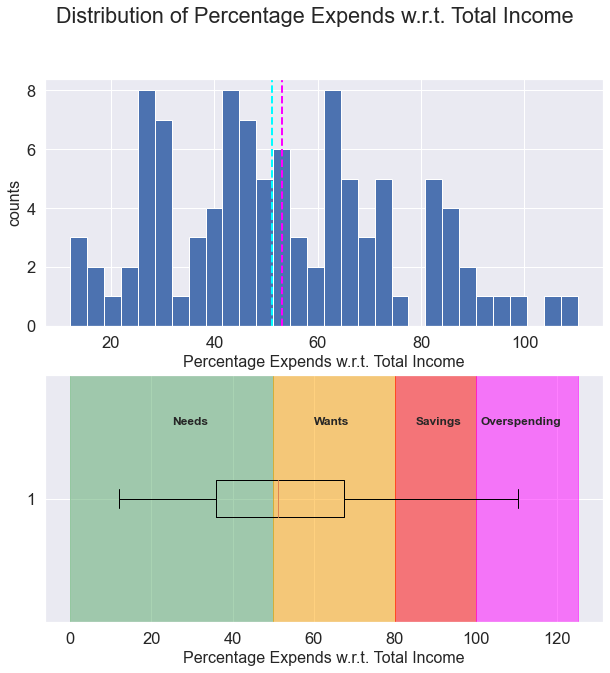

In [21]:
# Plot distribution of 
plot_distribution(results_df, 'pctg_expends', 'Percentage Expends w.r.t. Total Income',alpha = 0.5, annotation=True)

## Future Work

- We could benefit from expanding the number of data instances. This includes both by increasing the number of unique user ids and expanding the user history (i.e. number of months per user)
- Additionaly, we could augment our dataset by including more information on non-essential user expendings (i.e. wants categories)
- We could benefit from further segmenting our users. For example, we could try classifying users in different categories:
    - Users in different income bands
    - Users with/without automotive/child/education expenses 
    - Users that pay rent/morgages versus those that do not
- By analyzing users by segment we could find out if they have distinctive consumption patterns. Additionally, we could better understand expendings within each category and identify outlier/erroneous entries more effectively.
